<a href="https://colab.research.google.com/github/brenoskuk/BinaryCenterNet/blob/main/DataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cut data augmentation

## Imports

In [13]:
!pip install larq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


Check if using GPU

In [15]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# 1. Importing the dataset

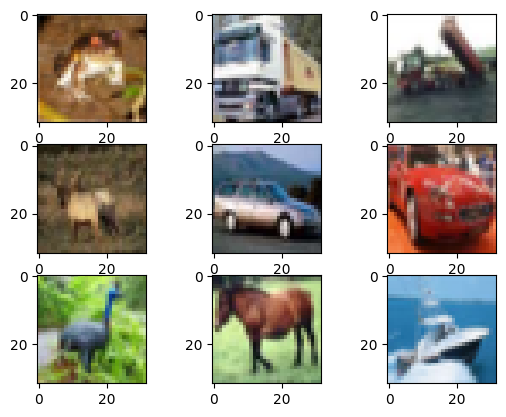

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
num_classes = 10

if True:
  img_rows, img_cols , channels= 32,32,3
  for i in range(0,9):
      plt.subplot(330 + 1 + i)
      plt.imshow(x_train[i])
  plt.show()

In [17]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values (between 0 and 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

In [18]:
# code from https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

# Declaring ImageDataGenerator

In [19]:
# Create an ImageDataGenerator with Cutout augmentation
datagen = ImageDataGenerator(
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False),
        rotation_range=0.3,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True)

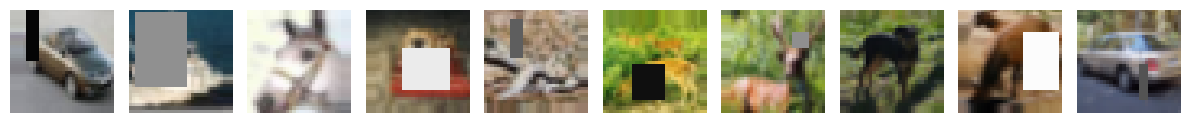

In [20]:
num_images = 10
# Generate augmented images
augmented_images = datagen.flow(x_train, y_train, batch_size=num_images)

# Retrieve augmented images
images, _ = next(augmented_images)

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 3))

for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Define scheduler for lr

In [21]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# lr scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)



# 2. Defining architechture

In [22]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2.3 Create, compile model and summary

In [38]:
# Taken from https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py Adapted from https://github.com/pytorch/vision/blob/v0.4.0/torchvision/models/resnet.py
import math
from tensorflow import keras
from tensorflow.keras import layers

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

# Get resnet18 weights

In [69]:
resnet18_imagenet = tf.keras.models.load_model('resnet18_imagenet.h5')


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [71]:
# Create resnet18 model to train on cifar
inputs = tf.keras.Input(shape=(28, 28, 3))
outputs = resnet18(inputs, num_classes = 10)
model = tf.keras.Model(inputs, outputs)

In [72]:
# Load weights on all conv layers weights

include_top = False

for layer, imagenet_layer in zip(model.layers, resnet18_imagenet.layers):
    if isinstance(layer, layers.Conv2D):
        layer.set_weights(imagenet_layer.get_weights()),
    elif isinstance(layer, layers.Dense) and include_top:
        layer.set_weights(imagenet_layer.get_weights()),
    elif isinstance(layer, layers.BatchNormalization):
        layer.set_weights(imagenet_layer.get_weights())

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

lq.models.summary(model)

+model_7 stats--------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 32-bit    Memory  32-bit MACs |
|                              (bit)                         x 1      (kB)              |
+---------------------------------------------------------------------------------------+
| input_20                         -   (-1, 28, 28, 3)         0         0            ? |
| conv1_pad                        -   (-1, 34, 34, 3)         0         0            ? |
| conv1                            -  (-1, 14, 14, 64)      9408     36.75      1843968 |
| bn1                              -  (-1, 14, 14, 64)       128      0.50            0 |
| relu1                            -  (-1, 14, 14, 64)         0         0            ? |
| maxpool_pad                      -  (-1, 16, 16, 64)         0         0            ? |
| maxpool                          -    (-1, 7, 7, 64)         0         0            0 |
| layer1.0

# 3. Training the model: Using cutout

In [ ]:
# train with image augmentation
history=model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_test, y_test),
                  callbacks=[lr_scheduler])

Learning rate:  0.001
Epoch 1/100


# 4. Model analysis

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(history.history['accuracy']))
print(np.max(history.history['val_accuracy']))

NameError: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(history.history['loss']))
print(np.min(history.history['val_loss']))